In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('../outputs/damo_yolo_ns/helmet/10/damoyolo_tinynasL18_Ns/2024-01-15-1915') as f:
    line_list = f.readlines()
len(line_list)

5255

In [3]:
total_loss_list = []
class_loss_list = []
box_loss_list = []
dfl_loss_list = []
iou_50_list = []
iou_50_95_list = []
learning_rate_list = []
for line in tqdm(line_list):
    if 'damo.apis.detector_trainer:train:365' in line:
        total_loss = [float(item.split(': ')[1]) for item in line.split(', ') if 'total_loss:' in item][0]
        total_loss_list.append(total_loss)

        class_loss = [float(item.split(': ')[1]) for item in line.split(', ') if 'loss_cls:' in item][0]
        class_loss_list.append(class_loss)

        box_loss = [float(item.split(': ')[1]) for item in line.split(', ') if 'loss_bbox:' in item][0]
        box_loss_list.append(box_loss)

        dfl_loss = [float(item.split(': ')[1]) for item in line.split(', ') if 'loss_dfl:' in item][0]
        dfl_loss_list.append(dfl_loss)

        lr = [float(item.split(': ')[1]) for item in line.split(', ') if 'lr:' in item][0]
        learning_rate_list.append(lr)
    elif 'pycocotools.cocoeval:_summarizeDets:460' in line:
        iou_50_95_list.append(float(line.split('= ')[-1]))
    elif 'pycocotools.cocoeval:_summarizeDets:461' in line:
        iou_50_list.append(float(line.split('= ')[-1]))

100%|██████████| 5255/5255 [00:00<00:00, 221133.78it/s]


In [4]:
def smooth(x, window_len=11, window='hanning'):
    x = np.asarray(x)
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[2 * x[0] - x[window_len - 1::-1], x, 2 * x[-1] - x[-1:-window_len:-1]]
    if window == 'flat':  #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')
    y = np.convolve(w / w.sum(), s, mode='same')

    return y[window_len:-window_len + 1]

In [5]:
total_loss_list_smothed = smooth(total_loss_list, 125)
class_loss_list_smothed = smooth(class_loss_list, 125)
box_loss_list_smothed = smooth(box_loss_list, 125)
dfl_loss_list_smothed = smooth(dfl_loss_list, 125)

iou_50_list_smothed = smooth(iou_50_list, 5)
iou_50_95_list_smothed = smooth(iou_50_95_list, 5)

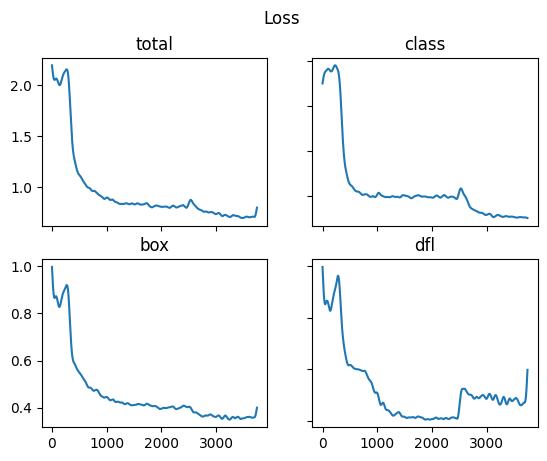

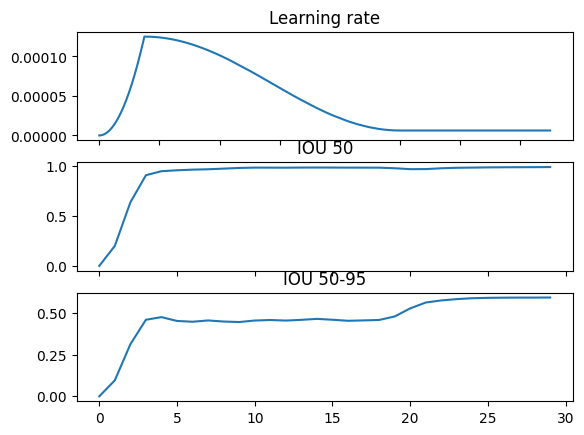

In [6]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(total_loss_list_smothed)
axs[0, 0].set_title('total')
axs[0, 1].plot(class_loss_list_smothed)
axs[0, 1].set_title('class')
axs[1, 0].plot(box_loss_list_smothed)
axs[1, 0].set_title('box')
axs[1, 1].plot(dfl_loss_list_smothed)
axs[1, 1].set_title('dfl')

for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Loss')
plt.show()

fig, axs = plt.subplots(3)
axs[0].plot(learning_rate_list)
axs[0].set_title('Learning rate')
axs[1].plot(iou_50_list_smothed)
axs[1].set_title('IOU 50')
axs[2].plot(iou_50_95_list_smothed)
axs[2].set_title('IOU 50-95')
for ax in axs.flat:
    ax.label_outer()

plt.show()